# 4-qubit tomography and data analysis
## Import stuff

In [1]:
import glob
import itertools
import pandas as pd
import numpy as np
import scipy as sp
from scipy import linalg
from scipy.optimize import least_squares,minimize
from numpy import random, linalg
import matplotlib.pyplot as plt
#import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm,ticker,colors,rc,font_manager
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
import os
fm = font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
fm.findfont("serif", rebuild_if_missing=False)
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 12})

## Some experimental parameters

In [2]:
# number of qubits
n_qbits = 4
# laser repetition rate
R = 8E7
# detector lists
#detectors = {'h1':1,'v1':2,'h2':3,'v2':4}
# interesting addresses
addresses_ini = {'h1':[1],'v1':[2],'h2':[3],'v2':[4],'h3':[5],'v3':[6],'h4':[7],'v4':[8], #singles
          'hhhh':[1,3,5,7],'hhvv':[1,3,6,8],'hvvh':[1,4,6,7],'vvhh':[2,4,5,7], #coincidences
          'hvhv':[1,4,5,8],'vhvh':[2,3,6,7],'vhhv':[2,3,5,8],'vvvv':[2,4,6,8],
          'hhhv':[1,3,5,8],'hhvh':[1,3,6,7],'hvhh':[1,4,5,7],'vhhh':[2,3,5,7],
          'hvvv':[1,4,6,8],'vvvh':[2,4,6,7],'vhvv':[2,3,6,8],'vvhv':[2,4,5,8],
          'h1v1':[1,2],'h2v2':[3,4]} #accidentals

addresses_sin = {'h1':1,'v1':2,'h2':3,'v2':4,'h3':5,'v3':6,'h4':7,'v4':8}
addresses_sin_a1 = {'h1':2,'v1':1,'h2':3,'v2':4,'h3':5,'v3':6,'h4':7,'v4':8} #A1 exchanged
addresses_sin_b2 = {'h1':1,'v1':2,'h2':3,'v2':4,'h3':5,'v3':6,'h4':8,'v4':7} #B2 exchanged
addresses_sin_a1b2 = {'h1':2,'v1':1,'h2':3,'v2':4,'h3':5,'v3':6,'h4':8,'v4':7} #B2 exchanged

# list of 4-fold coincicences
fourf_co = ['hhhh','hhhv','hhvh','hhvv',
          'hvhh','hvhv','hvvh','hvvv',
          'vhhh','vhhv','vhvh','vhvv',
          'vvhh','vvhv','vvvh','vvvv']

# measurement settings in order
settings = ['zzzz','zzzx','zzzy','zzxz','zzxx','zzxy','zzyz','zzyx','zzyy',
           'zxzz','zxzx','zxzy','zxxz','zxxx','zxxy','zxyz','zxyx','zxyy',
           'zyzz','zyzx','zyzy','zyxz','zyxx','zyxy','zyyz','zyyx','zyyy',
           'xzzz','xzzx','xzzy','xzxz','xzxx','xzxy','xzyz','xzyx','xzyy',
           'xxzz','xxzx','xxzy','xxxz','xxxx','xxxy','xxyz','xxyx','xxyy',
           'xyzz','xyzx','xyzy','xyxz','xyxx','xyxy','xyyz','xyyx','xyyy',
           'yzzz','yzzx','yzzy','yzxz','yzxx','yzxy','yzyz','yzyx','yzyy',
           'yxzz','yxzx','yxzy','yxxz','yxxx','yxxy','yxyz','yxyx','yxyy',
           'yyzz','yyzx','yyzy','yyxz','yyxx','yyxy','yyyz','yyyx','yyyy']

repeat = 100 #number of monte-carlo generations
m_per_turn = 600 #number of measurements per turn
mot_err = 0.2 #motor error in degrees

# correct for accidentals? 'theory' or 'no'
acc_corr = 'theory'


## QI definitions

In [3]:
#convert deg to rad
def theta(x):
    return x*np.pi/180

# Lambda-Half wave plate
def HWP(x):
    return np.array([[np.cos(2*theta(x)),np.sin(2*theta(x))],[np.sin(2*theta(x)),-np.cos(2*theta(x))]])

# QWP
def QWP(x):
    return np.array([[np.cos(theta(x))**2+1j*np.sin(theta(x))**2,(1-1j)*np.sin(theta(x))*np.cos(theta(x))],
            [(1-1j)*np.sin(theta(x))*np.cos(theta(x)),np.sin(theta(x))**2+1j*np.cos(theta(x))**2]])

#pauli matrices
s0 = np.eye(2)
sx = np.array([[0, 1],[ 1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])

#basis states
h = np.array([1, 0])
v = np.array([0, 1])

## Import Data

In [6]:
#function to generate cols_to_imp and cols_labels, given dict of detector channels as input
def Address(add_dict):
    addresses = {}
    # 4-photon addresses
    for el1 in dict(itertools.islice(add_dict.items(), 6,8)):
        for el2 in dict(itertools.islice(add_dict.items(), 4,6)):
            for el3 in dict(itertools.islice(add_dict.items(), 2,4)):
                for el4 in dict(itertools.islice(add_dict.items(), 0,2)):
                    addresses[el4[0]+el3[0]+el2[0]+el1[0]]=(2**(add_dict[el4]-1)+2**(add_dict[el3]-1)+
                    2**(add_dict[el2]-1)+2**(add_dict[el1]-1)+1)
                    
    # 3-photon addresses
    for el3 in dict(itertools.islice(add_dict.items(), 4,6)):
        for el2 in dict(itertools.islice(add_dict.items(), 2,4)):
            for el1 in dict(itertools.islice(add_dict.items(), 0,2)):
                addresses[el1+el2+el3]=(2**(add_dict[el1]-1)+2**(add_dict[el2]-1)+
                2**(add_dict[el3]-1)+1)
    for el4 in dict(itertools.islice(add_dict.items(), 6,8)):
        for el2 in dict(itertools.islice(add_dict.items(), 2,4)):
            for el1 in dict(itertools.islice(add_dict.items(), 0,2)):
                addresses[el1+el2+el4]=(2**(add_dict[el1]-1)+2**(add_dict[el2]-1)+
                2**(add_dict[el4]-1)+1)
    for el4 in dict(itertools.islice(add_dict.items(), 6,8)):
        for el3 in dict(itertools.islice(add_dict.items(), 4,6)):
            for el1 in dict(itertools.islice(add_dict.items(), 0,2)):
                addresses[el1+el3+el4]=(2**(add_dict[el1]-1)+2**(add_dict[el3]-1)+
                2**(add_dict[el4]-1)+1)
    for el4 in dict(itertools.islice(add_dict.items(), 6,8)):
        for el3 in dict(itertools.islice(add_dict.items(), 4,6)):
            for el2 in dict(itertools.islice(add_dict.items(), 2,4)):
                addresses[el2+el3+el4]=(2**(add_dict[el2]-1)+2**(add_dict[el3]-1)+
                2**(add_dict[el4]-1)+1)
                
    # singles
    for el in add_dict:
        addresses[el] = 2**(add_dict[el]-1)+1
        
    #sort dictionary
    addresses = {k: v for k, v in sorted(addresses.items(), key=lambda item: item[1])}
    # fill lists of columns to import and their labels
    # name colunms
    cols_to_imp = []
    cols_labels = []

    for el in addresses:
        cols_labels.append(el)
        cols_to_imp.append(addresses[el])

    return [addresses,cols_to_imp,cols_labels]


def data_import(folder=''):
# find all data files

    dat_files = glob.glob(folder+'*.dat')
    dat_files = sorted(dat_files, key=lambda item: int(item.split('_')[0])) #sort datafiles
    #print(dat_files[16:-16])
    #print(len(dat_files[16:-16]))
    counts_sing_turn = [] #holds the real data
    for i,dat_file in enumerate(dat_files[16:-16]):
        sett = settings[i]
        if sett[0]=='y' and sett[3]!='y':
            df = pd.read_csv(dat_file, sep=' ', header=None, names=Address(addresses_sin_a1)[2], usecols=Address(addresses_sin_a1)[1])
            setting_dict = {}
            # loop on turns
            for add in Address(addresses_sin_a1)[0]:
                setting_dict[add] = df[add].sum()
            counts_sing_turn.append(setting_dict)
        elif sett[0]!='y' and sett[3]=='y':
            df = pd.read_csv(dat_file, sep=' ', header=None, names=Address(addresses_sin_b2)[2], usecols=Address(addresses_sin_b2)[1])
            setting_dict = {}
            # loop on turns
            for add in Address(addresses_sin_b2)[0]:
                setting_dict[add] = df[add].sum()
            counts_sing_turn.append(setting_dict)
        elif sett[0]=='y' and sett[3]=='y':
            df = pd.read_csv(dat_file, sep=' ', header=None, names=Address(addresses_sin_a1b2)[2], usecols=Address(addresses_sin_a1b2)[1])
            setting_dict = {}
            # loop on turns
            for add in Address(addresses_sin_a1b2)[0]:
                setting_dict[add] = df[add].sum()
            counts_sing_turn.append(setting_dict)
        else:
            df = pd.read_csv(dat_file, sep=' ', header=None, names=Address(addresses_sin)[2], usecols=Address(addresses_sin)[1])
            setting_dict = {}
            # loop on turns
            for add in Address(addresses_sin)[0]:
                setting_dict[add] = df[add].sum()
            counts_sing_turn.append(setting_dict)

    return counts_sing_turn

print(data_import()[0])

# generate monte-carlo data, 'repeat' amount of sets
def MC_data(real_data, reps):
    
    counts = [real_data] #will hold total counts for each address, for every setting, for each repetition
    
    if reps<2:
        return counts
    
    for turn in range(reps-1):
        new_data_round = [] #will hold new MC-generated data, for all settings
#        counter = 0
        for i,data_dict in enumerate(real_data):
            new_data_dict = {} #will hold new MC-generated data, for one settings
            
            for el in data_dict:
#                counter += 1
#                print(counter+i*len(real_data))
                new_data_dict[el] = np.random.normal(data_dict[el],np.sqrt(data_dict[el]))
            new_data_round.append(new_data_dict)
        counts.append(new_data_round)

    return counts

#print(len(MC_data(data_import(),reps=3)))
#print(counts[0][40])
#print(counts[0][0])
#print(counts[1])

def exp_freq(reps):
# now create vectors for experimental frequencies
    f_v = [] #4-photon counts

    counts = MC_data(data_import(),reps)
    for i,turn in enumerate(counts):
        f_v_sing_turn = []
        for m_d in counts[i]:
            if acc_corr=='theory':
                acc = []
                acc.append((m_d['h1h2h3']*m_d['h4']+m_d['h1h2h4']*m_d['h3']+m_d['h1h3h4']*m_d['h2']+m_d['h2h3h4']*m_d['h1'])/(4*R*m_per_turn))
                acc.append((m_d['h1h2h3']*m_d['v4']+m_d['h1h2v4']*m_d['h3']+m_d['h1h3v4']*m_d['h2']+m_d['h2h3v4']*m_d['h1'])/(4*R*m_per_turn))
                acc.append((m_d['h1h2v3']*m_d['h4']+m_d['h1h2h4']*m_d['v3']+m_d['h1v3h4']*m_d['h2']+m_d['h2v3h4']*m_d['h1'])/(4*R*m_per_turn))
                acc.append((m_d['h1h2v3']*m_d['v4']+m_d['h1h2v4']*m_d['v3']+m_d['h1v3v4']*m_d['h2']+m_d['h2v3v4']*m_d['h1'])/(4*R*m_per_turn))
                acc.append((m_d['h1v2h3']*m_d['h4']+m_d['h1v2h4']*m_d['h3']+m_d['h1h3h4']*m_d['v2']+m_d['v2h3h4']*m_d['h1'])/(4*R*m_per_turn))
                acc.append((m_d['h1v2h3']*m_d['v4']+m_d['h1v2v4']*m_d['h3']+m_d['h1h3v4']*m_d['v2']+m_d['v2h3v4']*m_d['h1'])/(4*R*m_per_turn))
                acc.append((m_d['h1v2v3']*m_d['h4']+m_d['h1v2h4']*m_d['v3']+m_d['h1v3h4']*m_d['v2']+m_d['v2v3h4']*m_d['h1'])/(4*R*m_per_turn))
                acc.append((m_d['h1v2v3']*m_d['v4']+m_d['h1v2v4']*m_d['v3']+m_d['h1v3v4']*m_d['v2']+m_d['v2v3v4']*m_d['h1'])/(4*R*m_per_turn))
                acc.append((m_d['v1h2h3']*m_d['h4']+m_d['v1h2h4']*m_d['h3']+m_d['v1h3h4']*m_d['h2']+m_d['h2h3h4']*m_d['v1'])/(4*R*m_per_turn))
                acc.append((m_d['v1h2h3']*m_d['v4']+m_d['v1h2v4']*m_d['h3']+m_d['v1h3v4']*m_d['h2']+m_d['h2h3v4']*m_d['v1'])/(4*R*m_per_turn))
                acc.append((m_d['v1h2v3']*m_d['h4']+m_d['v1h2h4']*m_d['v3']+m_d['v1v3h4']*m_d['h2']+m_d['h2v3h4']*m_d['v1'])/(4*R*m_per_turn))
                acc.append((m_d['v1h2v3']*m_d['v4']+m_d['v1h2v4']*m_d['v3']+m_d['v1v3v4']*m_d['h2']+m_d['h2v3v4']*m_d['v1'])/(4*R*m_per_turn))
                acc.append((m_d['v1v2h3']*m_d['h4']+m_d['v1v2h4']*m_d['h3']+m_d['v1h3h4']*m_d['v2']+m_d['v2h3h4']*m_d['v1'])/(4*R*m_per_turn))
                acc.append((m_d['v1v2h3']*m_d['v4']+m_d['v1v2v4']*m_d['h3']+m_d['v1h3v4']*m_d['v2']+m_d['v2h3v4']*m_d['v1'])/(4*R*m_per_turn))
                acc.append((m_d['v1v2v3']*m_d['h4']+m_d['v1v2h4']*m_d['v3']+m_d['v1v3h4']*m_d['v2']+m_d['v2v3h4']*m_d['v1'])/(4*R*m_per_turn))
                acc.append((m_d['v1v2v3']*m_d['v4']+m_d['v1v2v4']*m_d['v3']+m_d['v1v3v4']*m_d['v2']+m_d['v2v3v4']*m_d['v1'])/(4*R*m_per_turn))
                norm = 0
                for i,comb in enumerate(fourf_co):
                    norm += max(m_d[comb]-acc[i],0)

                for i,comb in enumerate(fourf_co):
                    f_v_sing_turn.append(max((m_d[comb]-acc[i])/norm,0))
            elif acc_corr=='no':
                norm = sum(m_d[ff] for ff in fourf_co)
                #print(norm)
                for comb in fourf_co:
                    f_v_sing_turn.append(m_d[comb]/norm)
            else: print('Error with understanding if we want to correct for accs or not')
        f_v.append(f_v_sing_turn)
    return f_v

#f_v = exp_freq(data_import(),3)
#print(f_v[1][0:16])
#print(sum(f_v[0][0:16]))


{'h1': 50551016, 'v1': 51575332, 'h2': 48440234, 'v2': 42792436, 'h3': 56718133, 'h1h2h3': 183, 'v1h2h3': 204, 'h1v2h3': 17758, 'v1v2h3': 174, 'v3': 51516269, 'h1h2v3': 18040, 'v1h2v3': 18871, 'h1v2v3': 16536, 'v1v2v3': 188, 'h4': 55305363, 'h1h2h4': 178, 'v1h2h4': 15432, 'h1v2h4': 18117, 'v1v2h4': 14082, 'h1h3h4': 218, 'v1h3h4': 18321, 'h2h3h4': 207, 'hhhh': 0, 'vhhh': 30, 'v2h3h4': 151, 'hvhh': 34, 'vvhh': 31, 'h1v3h4': 204, 'v1v3h4': 16245, 'h2v3h4': 20293, 'hhvh': 37, 'vhvh': 3886, 'v2v3h4': 157, 'hvvh': 32, 'vvvh': 34, 'v4': 44238655, 'h1h2v4': 134, 'v1h2v4': 143, 'h1v2v4': 14558, 'v1v2v4': 133, 'h1h3v4': 18747, 'v1h3v4': 19090, 'h2h3v4': 18108, 'hhhv': 29, 'vhhv': 41, 'v2h3v4': 16428, 'hvhv': 3376, 'vvhv': 41, 'h1v3v4': 169, 'v1v3v4': 132, 'h2v3v4': 16062, 'hhvv': 39, 'vhvv': 36, 'v2v3v4': 134, 'hvvv': 25, 'vvvv': 0}


## Gamma matrices

In [74]:
def gamma_mat():
    s0 = np.eye(2)
    sx = np.array([[0, 1],[ 1, 0]])
    sy = np.array([[0, -1j],[1j, 0]])
    sz = np.array([[1, 0],[0, -1]])
    pm = [s0,sx,sy,sz]

    gammas = [] #will hold all 16 gammas
    for i in pm:
        for k in pm:
            for l in pm:
                for m in pm:
                    gammas.append(np.kron(i,np.kron(k,np.kron(l,m))))
    return gammas

## Projectors

In [75]:
def proj_err(settings, error=0):
    proj = [] #will hold all projectors
    h = np.array([1, 0])
    v = np.array([0, 1])
    # fill proj
    for s in settings:
    #for s in ['zzyx']:
        psi = []
        for lett in s:
            if lett == 'x':
                r = np.random.normal(22.5,error)
                psi.append(np.array([HWP(r)@h,HWP(r)@v]))
            elif lett == 'y':
                r = np.random.normal(45,error)
                psi.append(np.array([QWP(r)@h,QWP(r)@v]))
            elif lett == 'z':
                r = np.random.normal(0,error)
                psi.append(np.array([HWP(r)@h,HWP(r)@v]))
            else: print('Wrong setting definition!')
        #print(psi[0])
        for vv in psi[0]:
            for v1 in psi[1]:
                for v2 in psi[2]:
                    for v3 in psi[3]:
                        proj.append(np.kron(vv,np.kron(v1,np.kron(v2,v3))))
                        
    return proj


## M projector matrices

In [57]:
M = []

for vector in proj_err(settings, 0):
    M.append(np.outer(vector,vector.conj().T))
    
print(np.shape(M))

(1296, 16, 16)


## B matrix

In [93]:
def B_mat(meas_settings, mot_err):

    gammas = gamma_mat()
    proj = proj_err(meas_settings,mot_err)
    
    B = np.zeros((16*len(meas_settings),len(gammas)),dtype=complex)

    # fill B
    for i,g in enumerate(gammas):
        for k,vector in enumerate(proj):
            B[k,i] = vector@g@(vector.conj().T)

    # define inverted B matrix
    Bct = B.conj().T
    B_inv = np.linalg.inv(Bct@B)@(Bct)
    return B_inv

## LINEAR INVERSION - Density matrix

In [103]:
def lin_inv_tomo_poiss(data, meas_settings, reps):

    gammas = gamma_mat()
    B_inv = B_mat(meas_settings, 0)
    rho_lin = [np.zeros(np.shape(gammas[0]),dtype=complex) for i in range(reps)]
    f_v = data
    for turn in range(reps):

        for v,freq in enumerate(f_v[turn]):
            for m,gam in enumerate(gammas):
                tmp = B_inv[m,v]*gam*freq
                rho_lin[turn] += tmp

    return rho_lin

def lin_inv_tomo_mot(data, meas_settings, mot_err, reps):

    gammas = gamma_mat()
    rho_lin = [np.zeros(np.shape(gammas[0]),dtype=complex) for i in range(reps)]
    f_v = data[0]
    for turn in range(reps):
        B_inv = B_mat(meas_settings, mot_err)
        for v,freq in enumerate(f_v):
            for m,gam in enumerate(gammas):
                tmp = B_inv[m,v]*gam*freq
                rho_lin[turn] += tmp

    return rho_lin

rho_lin_poiss = lin_inv_tomo_poiss(exp_freq(repeat),settings,repeat)
rho_lin_mot = lin_inv_tomo_mot(exp_freq(repeat),settings,mot_err,repeat)

In [104]:


#rho_lin_mean = np.mean(rho_lin_poiss, axis=0) #average rho
#with np.printoptions(precision=2, suppress=True):
#    print((rho_lin_mean))
fid_list = []
for rho in rho_lin_mot:
    fid_list.append(fidelity(rho,dens(state)))
    
with np.printoptions(precision=3, suppress=True):
    print(fid_list)
    
print(fidelity(np.mean(rho_lin_poiss, axis=0),dens(state)), fidelity(np.mean(rho_lin_mot, axis=0),dens(state)))

[0.9065649363387535, 0.9067507975313824, 0.9067025885339144, 0.9064441462590714, 0.9068124913369797, 0.906606073108471, 0.9065728070106712, 0.9065346008186834, 0.9066720487617634, 0.9063803663141143, 0.9066855552970262, 0.9064052232967095, 0.9063880212438191, 0.9063879651478679, 0.906384957791907, 0.9066545840534851, 0.9065179538437758, 0.9062798568203861, 0.9064999498087737, 0.9064922188795419, 0.9067112051265932, 0.9066545582788043, 0.9067444072720678, 0.9066449447463332, 0.906691138836485, 0.9069047430247712, 0.90659581542644, 0.9065479083598105, 0.9065016872302849, 0.9066614698232003, 0.9065997158582346, 0.9067207952611588, 0.9064136959044425, 0.9064957555923021, 0.9069395289527669, 0.9067508539977998, 0.9066347580347398, 0.9065593881234437, 0.9065434091902468, 0.9066089600820895, 0.9064855033786694, 0.9066396079209704, 0.9068193353786395, 0.9068130260637215, 0.906569570366087, 0.906429319396807, 0.906424727510493, 0.9064430724292892, 0.9064723923837813, 0.9067887909440918, 0.90684

## Fidelity

In [140]:
def fidelity_old(state1,state2):
    pure = 0
    if len(np.shape(state1))==1:
        rho1 = np.dot(state1,state1.conj().transpose())
        pure = 1
    elif np.shape(state1)[1] == np.shape(state1)[0]:
        rho1 = state1
    else:
        print("State1 is not a vector or density matrix")

    if len(np.shape(state2))==1:
        rho2 = np.dot(state2,state2.conj().transpose())
        pure = 1
    elif np.shape(state2)[1] == np.shape(state2)[0]:
        rho2 = state2
    else:
        print("State1 is not a vector or density matrix")

    rho1 = rho1 / np.trace(rho1)
    rho2 = rho2 / np.trace(rho2)

    rho1 = (rho1+rho1.conj().transpose())/2


    if pure:
        val = np.trace(np.dot(rho1,rho2))
    else:
        val = np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rho1)@rho2@sp.linalg.sqrtm(rho1)))**2
        tmp = sp.linalg.sqrtm(rho1)
        a = np.dot(tmp,np.dot(rho2,tmp))
        ev = np.linalg.eig(a)[0]
        val = np.sum(ev**(0.5))**2
    val = np.real(val)

    return val

def fidelity(state1,state2):

    rho1 = state1
    rho2 = state2

#    rho1 = (rho1+rho1.conj().transpose())/2
    val = (np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rho1)@rho2@(sp.linalg.sqrtm(rho1)))))**2
#        tmp = sp.linalg.sqrtm(rho1)
#        a = np.dot(tmp,np.dot(rho2,tmp))
#        ev = np.linalg.eig(a)[0]
#        val = np.sum(ev**(0.5))**2
    val = np.real(val)

    return val

# GHZ^n state
def GHZ(nqub=4):
    ghz = np.zeros((2**nqub,1))
    ghz[0],ghz[-1] = 1/np.sqrt(2),1/np.sqrt(2)
    return ghz

# Convert pure vector state into density matrix
def dens(state):
    return state@np.conj(state.T)

phi_plus = np.array([[1,0,0,1],[0,0,0,0],[0,0,0,0],[1,0,0,1]]) / 2
state = np.zeros((16,1),dtype=complex)
state[5]=state[10]=1/np.sqrt(2)
#print(dens(state))
fidelity(rho_lin_mean,dens(state))

0.9065084969570534

## Concurrence and Tangle

In [14]:
def concurrence(rho):
    if min(np.shape(rho))==1:
        rho = np.dot(rho,rho.conj().transpose())
        #psi??, I think there something wrong here in m files.

    Z = np.array([[0,0,0,-1],[0,0,1,0],[0,1,0,0],[-1,0,0,0]])
    R = np.dot(rho,np.dot(Z,np.dot(rho.conj(),Z)))
    [r,right] = np.linalg.eig(R)
    #left = np.linalg.inv(right)
    r = np.real(r)

    tmp = np.sort(np.sqrt(r+0j))
    C = np.real(tmp[3]-tmp[2]-tmp[1]-tmp[0])
    C = np.max([C,0])

    return C

def tangle(rho):
    C = concurrence(rho)
    T = C**2

    return T

## Entanglement

In [15]:
def entanglement(rho):
    t = tangle(rho)
    x = (1 + np.sqrt(1-t))/2
    if x == 0:
        E = 0
    elif x == 1:
        E = 1
    else:
        E = -x*np.log2(x) - (1-x)*np.log2(1-x)

    return E

## Entropy and Linear entropy

In [16]:
def entropy(rho):
    [D,ignore] = np.linalg.eig(rho)
    E = np.real(D)
    S = 0
    for a in range(len(E)):
        if E[a] > 0:
            S = S - E[a]*np.log2(E[a])

    return S

def linear_entropy(rho):
    if min(np.shape(rho)) == 1:
        lin_e = 0
    else:
        d = len(rho)
        lin_e = d * np.real(1-np.trace(np.dot(rho,rho)))/(d-1)

    return lin_e

## Negativity

In [17]:
def partial_transpose_first(M,d):
    if np.shape(M)[0] == d:
        val = M.tranpose()
    else:
        Na = np.int(d)
        Nb = np.int(len(M)/d)
        Y = np.zeros([Nb,Nb,Na,Na])+0j
        val = np.zeros([len(M),len(M)])+0j
        for j in range(Nb):
            for k in range(Nb):
                Y[j,k] = M[j*Nb:j*Nb+Na,k*Nb:k*Nb+Na]
        for j in range(Nb):
            for k in range(Nb):
                val[j*Nb:j*Nb+Na,k*Nb:k*Nb+Na] = Y[k,j]

        return val

def partial_transpose(rho,n,D=np.nan):
    if min(np.shape(rho)) == 1:
            rho = np.dot(rho,rho.conj().transpose())

    if D is np.nan:
        n_qubit = np.log2(np.shape(rho)[0])
        if not n_qubit%1:
            D = 2 * np.ones(int(n_qubit))
        else:
            print('dimension of rho is incorrect.')
    if n<0:
        Na = 1.0
        Nb = 1.0
        Nc = np.prod(D)
    elif n==0:
        Na = 1.0
        Nb = D[n]
        Nc = np.prod(D[np.arange(n+1,len(D))])
    elif (n>0)&(n<len(D)):
        Na = np.prod(D[range(n-1)])
        Nb = D[n]
        Nc = np.prod(D[np.arange(n+1,len(D))])
    elif n==len(D):
        Na = np.prod(D[range(n-1)])
        Nb = D[n]
        Nc = 1.0
    elif n>len(D):
        Na = np.prod(D)
        Nb = 1.0
        Nc = 1.0

    if Na==1:
        rv = partial_transpose_first(rho,Nb)
    # I did't check from here
    else:
        sub_sizes = Nb*Nc
        Y = np.zeros([sub_sizes,sub_sizes,Na,Na])+0j
        for j in range(sub_sizes):
            for k in range(sub_sizes):
                Y[j,k] = rho[j*sub_sizes:j*sub_sizes+Na,k*sub_sizes:k*sub_sizes+Na]

        rv = np.zeros([len(rho),len(rho)])+0j

        for j in range(Na):
            for k in range(Na):
                rv[j*Nb:j*Nb+Na,k*Nb:k*Nb+Na] = partial_transpose_first(Y[j,k],Nb)

    return rv

def negativity(rho):
    if min(np.shape(rho)) == 1:
        rho = np.dot(rho,rho.conj().transpose())

    rho1 = partial_transpose(rho,0)
    val = -2*np.min(np.min(np.real(np.linalg.eig(rho1)[0])),0)

    return val

## Initialize for Maximum likelihood

In [141]:
# find inital guesses for T matrix
def density2tm(rho):
    d = np.shape(rho)[0]
    if d == 1:
        tm = np.real(np.sqrt(rho))
        return tm
    
    tm = np.zeros(np.shape(rho), dtype=complex)
    last_element = rho[d-1,d-1]
    tm[d-1,d-1] = np.real(np.sqrt(last_element))
    if last_element > 0:
        temp = rho[d-1,:d-1]
        tm[d-1,:d-1] = temp/np.sqrt(last_element)
        recurse = rho[:d-1,:d-1] - np.outer(temp.conj().transpose(),temp)/last_element

    else:
        tm[d-1,:d-1] = np.zeros(d-1)
        recurse = rho[:d-1,:d-1]

    tm[:d-1,:d-1] = density2tm(recurse)
        
    return tm   
    
def density2t(rho):
    tm = density2tm(rho)
    d = len(tm)
    
    idx = 0
    cur_length = d
    t = np.zeros(d**2)
    
    for j in range(d):
        t[np.arange(idx,idx+cur_length)] = np.real(np.diag(tm,-j))
        idx = idx + cur_length
        if j>0:
            t[np.arange(idx,idx+cur_length)] = np.imag(np.diag(tm,-j))
            idx = idx + cur_length
        cur_length = cur_length -1
        
    return t

def make_positive(rho_in):
    D,V = np.linalg.eig(rho_in)
    rho = np.zeros(np.shape(rho_in))
    for j in range(len(D)):
        rho = rho + np.abs(D[j])*np.outer(V[:,j],V[:,j].conj().transpose())
    rho = (rho + rho.conj().transpose())/2.0
    
    return rho

## Maximum Likelyhood

In [143]:
%%time
opt_turns = 1
# physical density matrix
def t_matrix(t):
    d = np.int(np.sqrt(len(t)))
    
    idx = 0
    cur_length = d
    tm = np.zeros([d,d])
    
    for j in range(np.int(d)):
        tm = tm + 1*np.diag(t[np.arange(idx,idx+cur_length)],-j)
        idx = idx + cur_length
        
        if j>0:
            tm = tm + 1j*np.diag(t[np.arange(idx,idx+cur_length)],-j)
            idx = idx + cur_length
        
        cur_length = cur_length - 1
        
    return tm

def MLrho(t):
    # T matrix
    Tm = t_matrix(t)
    return Tm.conj().T@Tm/(np.trace(Tm.conj().T@Tm))

# likelyhood function
def LikeFun(t,proj,data):
    like = .0
    for v,vec in enumerate(proj):
        #like += np.real(vec.conj().T@MLrho(t)@vec-data[v])/np.sqrt(np.real(2*vec.conj().T@MLrho(t)@vec))
        like += (vec.conj().T@MLrho(t)@vec-data[v])**2/(2*vec.conj().T@MLrho(t)@vec)
    return np.real(like)

# minimisation routine
init = np.ones(16**2)
min_result = []
#bnd = (-1,1)
#bound = ((bnd,)*(2*n_qbits)**2)
#print(bounds)

##Print callback function
def printx(Xi):
    global Nfeval
    global fout
    fout.write(str(Nfeval) +', t = '+ str(Xi) + '\n' + 'rho = ' + str(MLrho(Xi)) + '\n')
    Nfeval += 1


fout = open('4-tomo_BFGS_steps_sw_corrected.txt','w')

for turn in range(opt_turns):
    %time rho0 = make_positive(rho_lin[turn])
    rho0 = rho0/(np.trace(rho0))
#    t0 = np.real(density2t(rho0))
    %time t0_lin = np.real(density2t(rho_lin_poiss[turn]))
#    print(t0)
    Nfeval = 1
    proj = proj_err(settings,0)
    f_v = exp_freq(repeat)
    mini = minimize(LikeFun,t0_lin,args=(proj,f_v[turn]), method='BFGS', callback=printx, tol=0.001, options={'disp': True})
    #if mini.success:
    min_result.append(mini)

rho_ML = MLrho(min_result[0].x)
#rho_ML_mean = np.mean(rho_ML, axis=0)
#print(rho_ML)

# check optimisation result
print([min_result[turn].success for turn in range(opt_turns)])

CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 1.29 ms
CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 2.26 ms
Optimization terminated successfully.
         Current function value: 0.168711
         Iterations: 114
         Function evaluations: 30960
         Gradient evaluations: 120
[True]
CPU times: user 7h 26min 37s, sys: 26.7 s, total: 7h 27min 3s
Wall time: 7h 27min 15s


## Print results out

In [146]:
# DENSITY MATRIX
rho_lin_mean = rho_lin_poiss[0]

print('\n##########################')
print('#    LINEAR INVERSION    #')
print('##########################\n')

print('Rho = ',rho_lin_mean)
with np.printoptions(precision=3, suppress=True):
    print('Eigenvalues of rho: ',np.linalg.eig(rho_lin_mean)[0])
    print('Trace of rho: {:.3f}'.format(np.trace(rho_lin_mean)))
    print('Trace of rho²: {:.3f}'.format(np.trace(rho_lin_mean@rho_lin_mean)))
#    print('rho - rho²= ',rho_lin_mean-(rho_lin_mean@rho_lin_mean))
#print(np.std(rho_lin, axis=0))

# FIDELITY
fid_list_poiss = [fidelity(rho_lin_poiss[i],dens(state)) for i in range(len(rho_lin_poiss))]
fid_list_mot = [fidelity(rho_lin_mot[i],dens(state)) for i in range(len(rho_lin_mot))]
#print('Average fidelity: ',fidelity(rho_lin_mean,phi_plus))
print('Data fidelity: {:.4f}'.format(fid_list_poiss[0]))
print('Fidelity uncertainty: ')
print('Poissonian: +{:.4f}-{:.4f}'.format(np.percentile(fid_list_poiss,50+34.1)
      -np.median(fid_list_poiss),np.median(fid_list_poiss)-np.percentile(fid_list_poiss,50-34.1)))
print('Motor repeatability: +{:.4f}-{:.4f}'.format(np.percentile(fid_list_mot,50+34.1)
      -np.median(fid_list_mot),np.median(fid_list_mot)-np.percentile(fid_list_mot,50-34.1)))

# DENSITY MATRIX
print('\n############################')
print('#    MAXIMUM LIKELYHOOD    #')
print('############################\n')

print('Rho = ',rho_ML)
with np.printoptions(precision=3, suppress=True):
    print('Eigenvalues of rho: ',np.linalg.eig(rho_ML)[0])
    print('Trace of rho: {:.3f}'.format(np.trace(rho_ML)))
    print('Trace of rho²: {:.3f}'.format(np.trace(rho_ML@rho_ML)))
#    print('rho - rho²= ',rho_ML_mean-(rho_ML_mean@rho_ML_mean))

# FIDELITY
fid_ML = fidelity(rho_ML,dens(state))
#print('Average fidelity: ',fidelity(rho_ML_mean,phi_plus))
print('ML fidelity: {:.4f}'.format(fid_ML))

print('\n####################')
print('#    COMPARISON    #')
print('####################\n')

with np.printoptions(precision=3, suppress=True):
    print('Fidelity of the two methods: {:.3f}'.format(fidelity(rho_lin_mean,rho_ML)))


##########################
#    LINEAR INVERSION    #
##########################

Rho =  [[-8.77550258e-04+4.49514997e-23j  1.02649303e-03-2.35606106e-03j
   1.31247771e-04+1.19657501e-03j -5.77914746e-04-1.17068897e-03j
   5.53789471e-04+1.42181748e-05j  4.33922811e-04+1.24342437e-03j
   7.68437268e-04+2.16870710e-03j -8.34531357e-04+4.28986044e-05j
   9.31501416e-04+6.70793026e-05j  2.92583329e-04-8.72868498e-04j
   3.85747484e-05-1.81870361e-04j -3.80202365e-04+2.66923916e-03j
   8.06249557e-04+1.62362133e-04j -3.04769912e-03+4.17458247e-03j
   2.70060738e-03-6.45479047e-04j -1.21590449e-04+9.05898446e-04j]
 [ 1.02649303e-03+2.35606106e-03j  6.26527040e-03-8.62208359e-22j
  -2.08174937e-03-3.47002381e-04j  1.85248988e-03-3.89206074e-04j
  -7.40314725e-04-1.81340243e-04j  2.96827279e-04+1.40920095e-02j
   1.91104280e-03+1.15992795e-03j  1.50928570e-04-2.14963031e-03j
  -1.50511284e-03-1.28690228e-03j  4.08556724e-04+1.64805477e-03j
   4.20267886e-03+1.20538056e-02j -1.60993234e-03-9

## Plotting

<ipython-input-152-dc3b9c9b0c31>:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


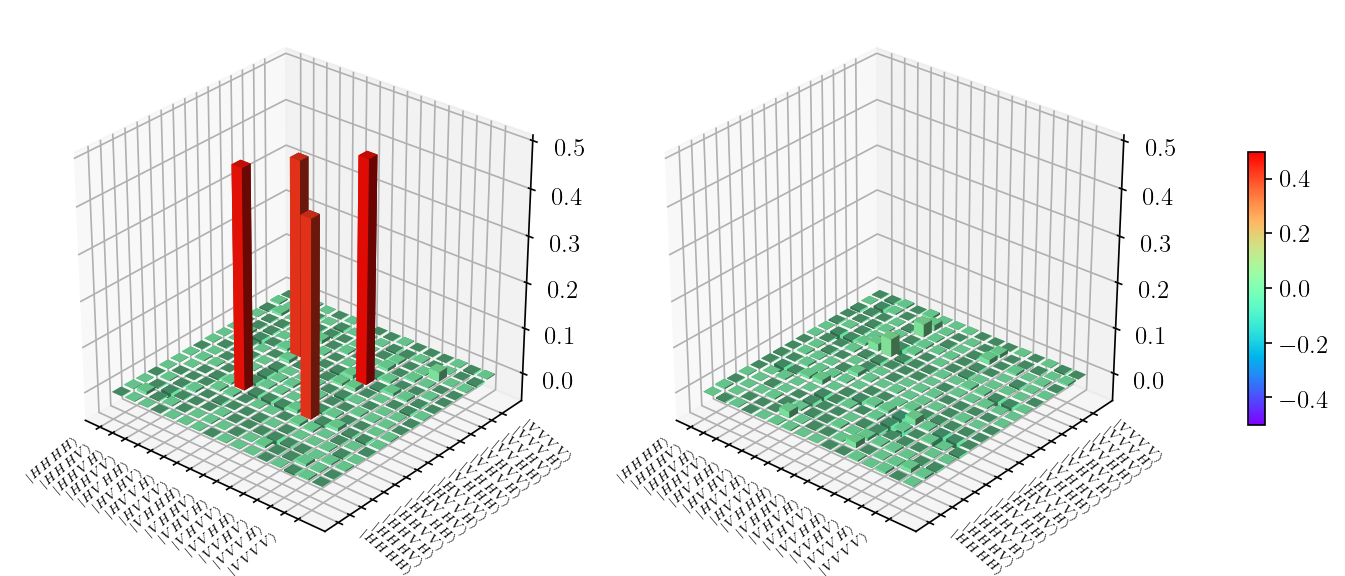

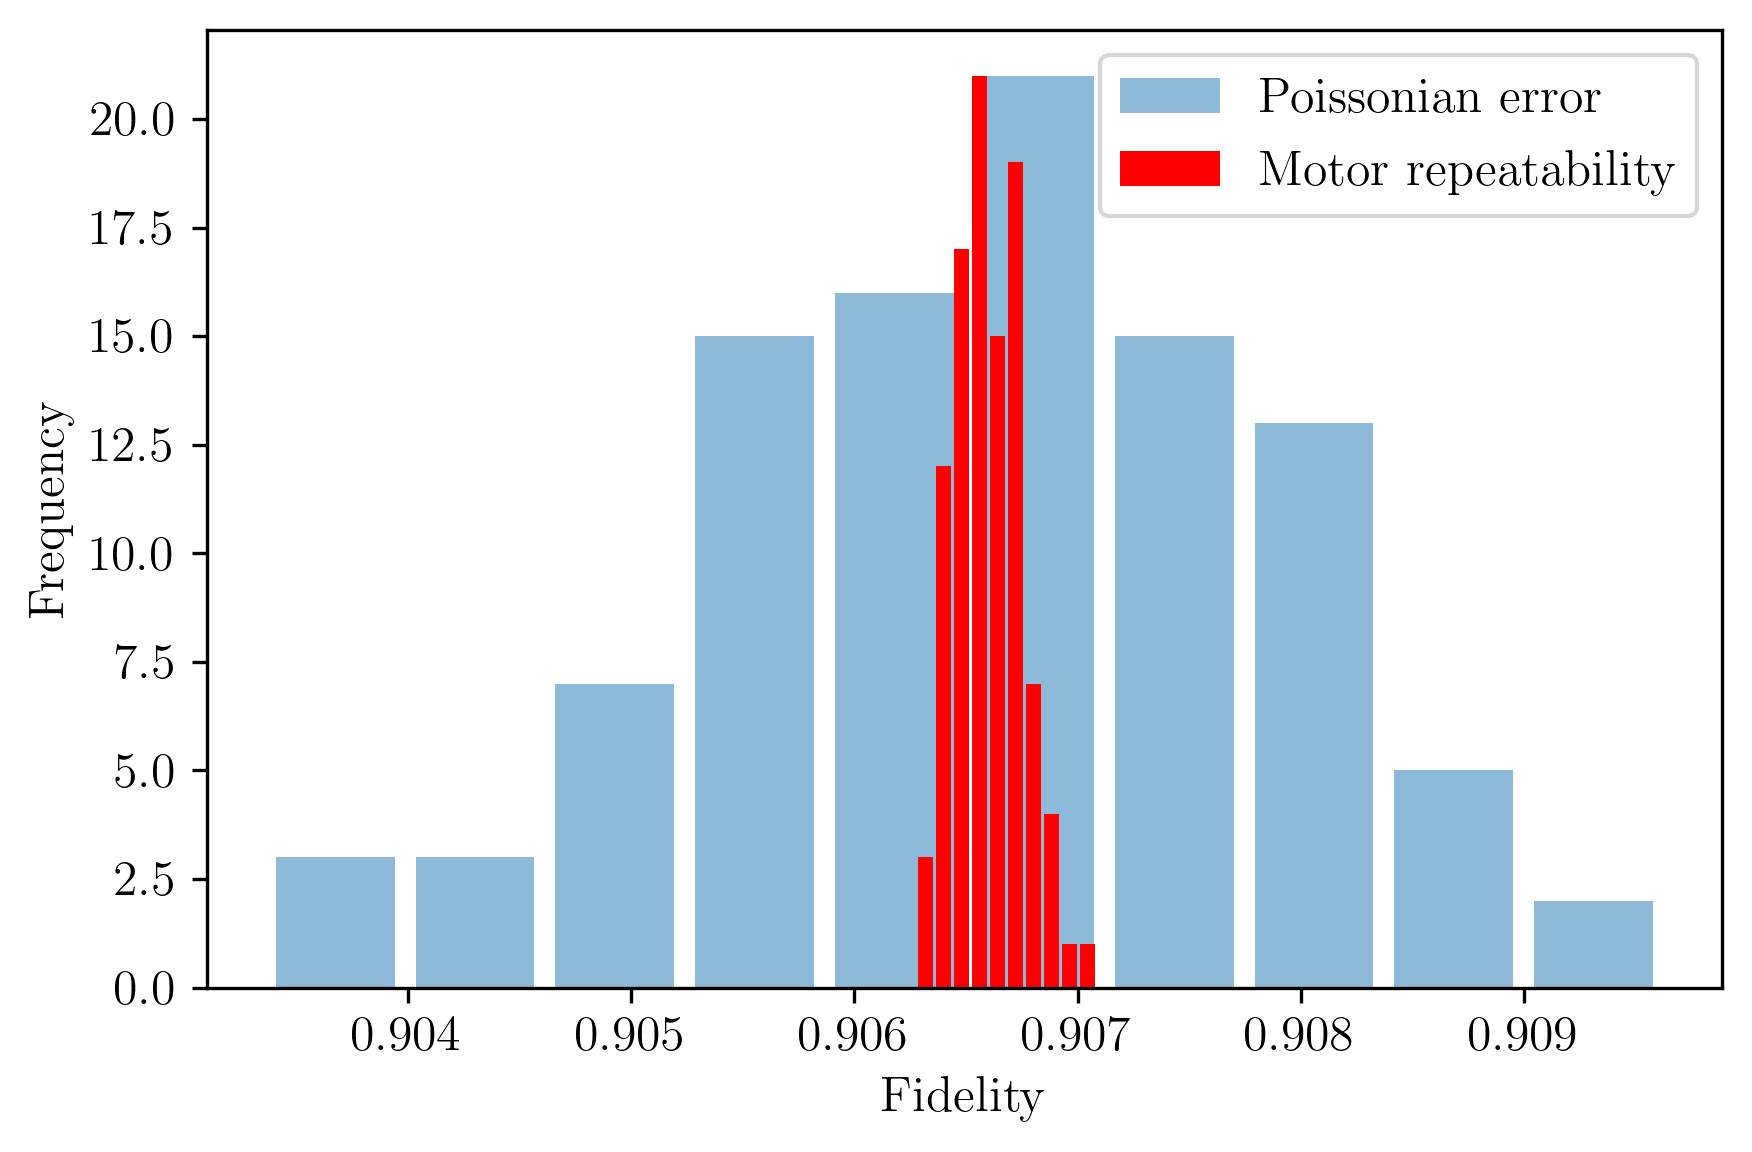

In [152]:
plt.rcParams.update({'font.size': 12})
rho_lin_mean = rho_lin_poiss[0] #plot linear inversion matrix
#rho_lin_mean = rho_ML #plot ML matrix
# Make x-y points
X = np.arange(n_qbits**2)
Y = np.arange(n_qbits**2)

X, Y = np.meshgrid(X, Y)

Xi = X.flatten()
Yi = Y.flatten()
Zi = np.zeros(rho_lin_mean.size)

dx = .75 * np.ones(rho_lin_mean.size)
dy = .75 * np.ones(rho_lin_mean.size)
dz_re = np.real(rho_lin_mean).flatten()
dz_im = np.imag(rho_lin_mean).flatten()

fig1 = plt.figure(figsize=(12, 4), dpi=150)

# set up the axes for the first plot
cmap1=plt.cm.rainbow(plt.Normalize(-.5,.5)(dz_re))

ax1 = fig1.add_subplot(1, 3, 1, projection='3d')
ax1.bar3d(Xi, Yi, Zi, dx, dy, dz_re, color=cmap1)


# Customize the axis.
labs = [r'$\left|HHHH\right\rangle$',r'$\left|HHHV\right\rangle$',
        r'$\left|HHVH\right\rangle$',r'$\left|HHVV\right\rangle$',
        r'$\left|HVHH\right\rangle$',r'$\left|HVHV\right\rangle$',
        r'$\left|HVVH\right\rangle$',r'$\left|HVVV\right\rangle$',
        r'$\left|VHHH\right\rangle$',r'$\left|VHHV\right\rangle$',
        r'$\left|VHVH\right\rangle$',r'$\left|VHVV\right\rangle$',
        r'$\left|VVHH\right\rangle$',r'$\left|VVHV\right\rangle$',
        r'$\left|VVVH\right\rangle$',r'$\left|VVVV\right\rangle$']
ax1.set_xticks(range(n_qbits**2))
ax1.set_xticklabels(labs,ha='right', va='center', rotation=40)
ax1.set_yticks(range(n_qbits**2))
ax1.set_yticklabels(labs,ha='left', va='center', rotation=-40)
ax1.set_zlim(-.05,.5)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(6)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(6)
    
# set up the axes for the second plot
ax2 = fig1.add_subplot(1, 3, 2, projection='3d')
cmap2=plt.cm.rainbow(plt.Normalize(-.5,.5)(dz_im))
ax2.bar3d(Xi, Yi, Zi, dx, dy, dz_im, color=cmap2)
ax2.set_xticks(range(n_qbits**2))
ax2.set_xticklabels(labs,ha='right', va='center', rotation=40)
ax2.set_yticks(range(n_qbits**2))
ax2.set_yticklabels(labs,ha='left', va='center', rotation=-40)
#ax2.set_zticks([0,.2,.4])
ax2.set_zlim(-.05,.5)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(6)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(6)
# add colorbar
#ax3 = fig1.add_subplot(1, 3, 3)
m = plt.cm.ScalarMappable(cmap=cm.rainbow)
m.set_array(np.real(rho_lin_mean))
m.set_clim(-.5, .5)
#plt.gca().set_visible(False)


axins = inset_axes(ax2,
                   width="3%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='center left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=2,
                   )
fig1.colorbar(m, cax=axins, shrink=1, aspect=20)

plt.tight_layout()
ax1.view_init(30, -50)
ax2.view_init(30, -50)
plt.draw()

# plot fidelity histogram
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
n_lin,bins_lin,patches_lin = ax.hist(fid_list_poiss, alpha=0.5, rwidth = .85, label='Poissonian error')
ax.hist(fid_list_mot, alpha=1, rwidth = .85, color='r', label='Motor repeatability')
ax.legend()
#ax.set_xlim(.993,1)
ax.set_xlabel('Fidelity')
ax.set_ylabel('Frequency')
fig.tight_layout()
plt.draw()

# fidelity in time
#fig_ft, ax = plt.subplots(nrows=1, ncols=1, dpi=150)
#ax.plot(fid_list)
#fig1.savefig("rho_4ph_ML.pdf", format='pdf', bbox_inches='tight')
#fig.savefig("rho_4ph_histogram_poiss_vs_mot_err.pdf", format='pdf', bbox_inches='tight')
# show plots
#plt.show()

In [12]:
print(Address(addresses_sin))

[{'h1': 2, 'v1': 3, 'h2': 5, 'v2': 9, 'h3': 17, 'h1h2h3': 22, 'v1h2h3': 23, 'h1v2h3': 26, 'v1v2h3': 27, 'v3': 33, 'h1h2v3': 38, 'v1h2v3': 39, 'h1v2v3': 42, 'v1v2v3': 43, 'h4': 65, 'h1h3h4': 82, 'v1h3h4': 83, 'h2h3h4': 85, 'hhhh': 86, 'vhhh': 87, 'v2h3h4': 89, 'hvhh': 90, 'vvhh': 91, 'h1v3h4': 98, 'v1v3h4': 99, 'h2v3h4': 101, 'hhvh': 102, 'vhvh': 103, 'v2v3h4': 105, 'hvvh': 106, 'vvvh': 107, 'v4': 129, 'h1h3v4': 146, 'v1h3v4': 147, 'h2h3v4': 149, 'hhhv': 150, 'vhhv': 151, 'v2h3v4': 153, 'hvhv': 154, 'vvhv': 155, 'h1v3v4': 162, 'v1v3v4': 163, 'h2v3v4': 165, 'hhvv': 166, 'vhvv': 167, 'v2v3v4': 169, 'hvvv': 170, 'vvvv': 171}, [2, 3, 5, 9, 17, 22, 23, 26, 27, 33, 38, 39, 42, 43, 65, 82, 83, 85, 86, 87, 89, 90, 91, 98, 99, 101, 102, 103, 105, 106, 107, 129, 146, 147, 149, 150, 151, 153, 154, 155, 162, 163, 165, 166, 167, 169, 170, 171], ['h1', 'v1', 'h2', 'v2', 'h3', 'h1h2h3', 'v1h2h3', 'h1v2h3', 'v1v2h3', 'v3', 'h1h2v3', 'v1h2v3', 'h1v2v3', 'v1v2v3', 'h4', 'h1h3h4', 'v1h3h4', 'h2h3h4', 'hhh